In [1]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import csv
import os
import tarfile
from urllib.parse import urlparse
from urllib.request import urlretrieve
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
import os

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
!pip install -q livelossplot==0.3.3
!pip install -q ipython-autotime
%load_ext autotime

time: 373 µs (started: 2022-10-30 16:52:25 +00:00)


In [7]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = 'preprocessed-hair/'+X_train['image']+ '.jpg'
X_test['image'] = 'preprocessed-hair/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = 'preprocessed-hair'


time: 668 ms (started: 2022-10-30 16:52:25 +00:00)


In [8]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 1.81 ms (started: 2022-10-30 16:52:26 +00:00)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 250 ms (started: 2022-10-30 16:52:26 +00:00)


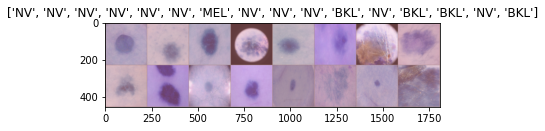

time: 393 ms (started: 2022-10-30 16:52:26 +00:00)


In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [11]:
class FusionMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

    def update(self, output, label):
        length = output.shape[0]
        for i in range(length):
            self.matrix[int(output[i]), int(label[i])] += 1

    def get_fusion_matrix(self):
        return self.matrix

    def get_rec_per_class(self):
        rec = np.array(
            [
                self.matrix[i, i] / self.matrix[:, i].sum()
                for i in range(self.num_classes)
            ]
        )
        rec[np.isnan(rec)] = 0
        return rec

    def get_pre_per_class(self):
        pre = np.array(
            [
                self.matrix[i, i] / self.matrix[i, :].sum()
                for i in range(self.num_classes)
            ]
        )
        pre[np.isnan(pre)] = 0
        return pre

    def get_accuracy(self):
        acc = (
            np.sum([self.matrix[i, i] for i in range(self.num_classes)])
            / self.matrix.sum()
        )
        return acc

    # convert multi-classification into binary classification tasks, and calculate the accuracy.
    def get_binary_accuracy(self, class_no):
        class_no = int(class_no)
        if class_no >= self.num_classes or class_no < 0:
            raise AttributeError(
                "Parameter class_no must less than the number of class.")

        error_num = 0
        for i in range(self.num_classes):
            error_num += self.matrix[i, class_no]
            error_num += self.matrix[class_no, i]
        error_num -= 2 * self.matrix[class_no, class_no]
        ok_num = self.matrix.sum() - error_num
        acc = ok_num / self.matrix.sum()
        return acc

    def get_balance_accuracy(self):
        rec = self.get_rec_per_class()
        bacc = np.mean(rec)
        return bacc

    def get_f1_score(self):
        recall = self.get_rec_per_class()
        precision = self.get_pre_per_class()
        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_score[np.isnan(f1_score)] = 0
        return np.mean(f1_score)

    def plot_confusion_matrix(self, normalize = False, cmap=plt.cm.Blues):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = self.matrix.T

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=np.arange(self.num_classes), yticklabels=np.arange(self.num_classes),
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return fig

time: 3.36 ms (started: 2022-10-30 16:52:26 +00:00)


In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 3.44 ms (started: 2022-10-30 16:52:26 +00:00)


/tmp/ipykernel_4251/574004566.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [13]:
model=models.vgg19(pretrained=False)
model.classifier[6]=nn.Sequential(nn.Linear(4096, 8), nn.Sigmoid())
checkpoint = torch.load('hair/vgg19-hair/resnet50_wt_epoch_19_batch_78_auc_0.5.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

time: 4.33 s (started: 2022-10-30 16:52:26 +00:00)


sensitivity-[1. 0. 0. 0. 0. 0. 0. 0.]
specicivity-[0.17857143 0.         0.         0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.125
Confusion Matrix
Figure(432x288)
f1-score
0.03787878787878788
auc-list


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
accuracy-list


[0.82142857 0.49172932 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.5
mean-auc0.875


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


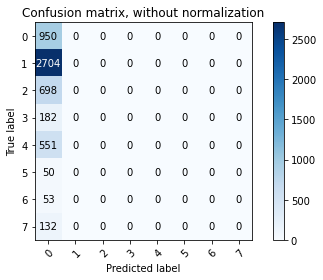

time: 7.46 s (started: 2022-10-30 16:52:31 +00:00)


In [14]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [15]:
model1=models.resnet50(pretrained=False)
model1.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('hair/resnet50-hair/resnet50_wt_epoch_9_batch_78_auc_0.6426.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 556 ms (started: 2022-10-30 16:52:38 +00:00)


sensitivity-[0.36105263 0.9160503  0.         0.         0.16878403 0.
 0.         0.        ]
specicivity-[0.39334862 0.6272474  0.         0.         0.18825911 0.
 0.         0.        ]
Balanced Accuracy
0.18073586955938098
Confusion Matrix
Figure(432x288)
f1-score
0.16239078066511958


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


auc-list


[0.68499049 0.85862094 0.75015731 0.55707527 0.57628194 0.44252941
 0.67312673 0.59787958]
accuracy-list


[0.83402256 0.71860902 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6425827072880105
mean-auc0.9049342105263158


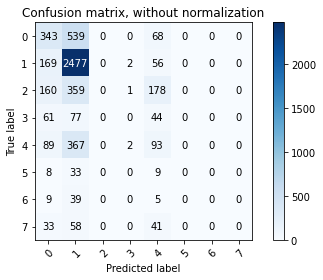

time: 5.11 s (started: 2022-10-30 16:52:39 +00:00)


In [16]:
auc2,acc2,pred_lst2,gt_lst2=compute_predictions(model1)

In [17]:
model2=models.vit_b_32(pretrained=False)
model2.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('hair/vit32-b-hair/resnet50_wt_epoch_13_batch_78_auc_0.6762.pt')
model2.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model2.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

time: 1.43 s (started: 2022-10-30 16:52:44 +00:00)


sensitivity-[0.00842105 0.92529586 0.63753582 0.         0.         0.
 0.         0.        ]
specicivity-[0.61538462 0.64418126 0.31271961 0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.19640659090483198
Confusion Matrix
Figure(432x288)
f1-score
0.1494738721283978
auc-list


[0.47524762 0.86093586 0.79056716 0.70248397 0.57540723 0.6643074
 0.67075167 0.66954335]
accuracy-list


[0.82142857 0.72086466 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6761555331895623
mean-auc0.9036419172932331


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


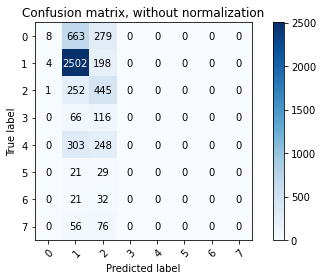

time: 6.06 s (started: 2022-10-30 16:52:45 +00:00)


In [18]:
auc3,acc3,pred_lst3,gt_lst3=compute_predictions(model2)

In [19]:
model3=models.densenet121(pretrained=False)
model3.classifier=nn.Sequential(nn.Linear(1024, 8), nn.Sigmoid())
checkpoint = torch.load('hair/densenet121-hair/resnet50_wt_epoch_3_batch_78_auc_0.6731.pt')
model3.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model3.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

time: 396 ms (started: 2022-10-30 16:52:51 +00:00)


sensitivity-[0.37789474 0.73890533 0.49140401 0.         0.         0.
 0.         0.        ]
specicivity-[0.37010309 0.70376893 0.22700199 0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.2010255092184013
Confusion Matrix
Figure(432x288)
f1-score
0.17567691842706096
auc-list


[0.73466578 0.7971195  0.74192104 0.63129708 0.65329246 0.58983681
 0.65767989 0.57896574]
accuracy-list


[0.82349624 0.66654135 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6730972869985155
mean-auc0.897109962406015


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


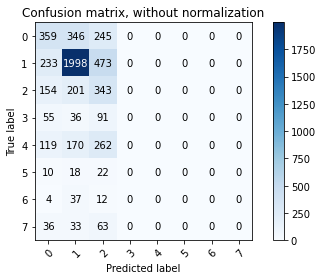

time: 9.09 s (started: 2022-10-30 16:52:52 +00:00)


In [20]:
auc4,acc4,pred_lst4,gt_lst4=compute_predictions(model3)

Computing Test Predictions
auc-list


[0.73386776 0.86686984 0.76041239 0.64148566 0.6553214  0.59826945
 0.67253924 0.59447647]
accuracy-list


[0.82142857 0.65244361 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.690405276005571
mean-auc0.8950892857142857
sensitivity-[0.35578947 0.89718935 0.4025788  0.         0.         0.
 0.         0.        ]
specicivity-[0.38895282 0.67239468 0.33333333 0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.20694470241978014
Confusion Matrix
Figure(432x288)
f1-score
0.18812819540124828


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


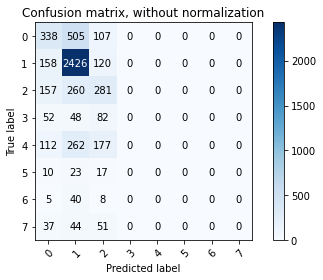

time: 24.4 s (started: 2022-10-30 16:53:01 +00:00)


In [21]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    #print('\n')
    #print(auc_lst)
    #print('\n')
    #print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    #print(auc)
    #print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

print('Computing Test Predictions')


auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)
auc3,acc3,pred_lst3,gt_lst3 = compute_predictions(model2)
auc4,acc4,pred_lst4,gt_lst4 = compute_predictions(model3)
pred_lst = (pred_lst1+pred_lst2+pred_lst3+pred_lst4)/4
gt_lst = (gt_lst1+gt_lst2+gt_lst3+gt_lst4)/4
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)


In [22]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = 'preprocessed-segment/'+X_train['image']+ '.jpg'
X_test['image'] = 'preprocessed-segment/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = 'preprocessed-segment'


time: 777 ms (started: 2022-10-30 16:53:25 +00:00)


In [23]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 1.87 ms (started: 2022-10-30 16:53:26 +00:00)


In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 298 ms (started: 2022-10-30 16:53:26 +00:00)


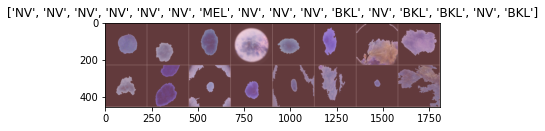

time: 501 ms (started: 2022-10-30 16:53:26 +00:00)


In [25]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [26]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 2.73 ms (started: 2022-10-30 16:53:27 +00:00)


In [27]:
model=models.vgg19(pretrained=False)
model.classifier[6]=nn.Sequential(nn.Linear(4096, 8), nn.Sigmoid())
checkpoint = torch.load('segment/vgg19-segment/resnet50_wt_epoch_15_batch_78_auc_0.5.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

time: 3.09 s (started: 2022-10-30 16:53:27 +00:00)


sensitivity-[1. 0. 0. 0. 0. 0. 0. 0.]
specicivity-[0.17857143 0.         0.         0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.125
Confusion Matrix
Figure(432x288)
f1-score
0.03787878787878788
auc-list


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
accuracy-list


[0.82142857 0.49172932 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.5
mean-auc0.875


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


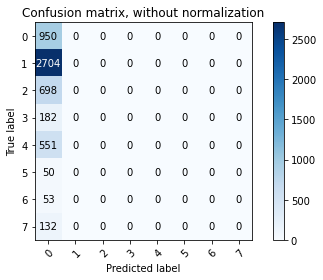

time: 8.24 s (started: 2022-10-30 16:53:30 +00:00)


In [28]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [29]:
model1=models.resnet50(pretrained=False)
model1.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('segment/resnet50-segment/resnet50_wt_epoch_15_batch_78_auc_0.6562.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 512 ms (started: 2022-10-30 16:53:38 +00:00)


sensitivity-[0.13684211 0.89718935 0.18767908 0.         0.22867514 0.
 0.         0.        ]
specicivity-[0.35230352 0.61371111 0.33762887 0.         0.20723684 0.
 0.         0.        ]
Balanced Accuracy
0.18129820919828654
Confusion Matrix
Figure(432x288)
f1-score
0.17308212399520675
auc-list


[0.65426617 0.80462233 0.7132727  0.6453718  0.64398781 0.56721822
 0.59751174 0.62402675]
accuracy-list


[0.82142857 0.67819549 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.656284689128976
mean-auc0.8983082706766917


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


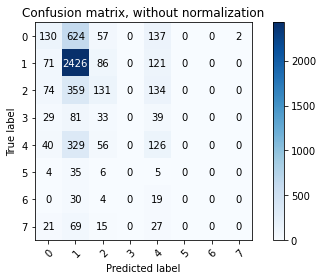

time: 4.8 s (started: 2022-10-30 16:53:39 +00:00)


In [30]:
auc2,acc2,pred_lst2,gt_lst2=compute_predictions(model1)

In [31]:
model2=models.vit_b_32(pretrained=False)
model2.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('segment/vit32b-segment/resnet50_wt_epoch_9_batch_78_auc_0.6816.pt')
model2.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model2.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

time: 1.43 s (started: 2022-10-30 16:53:43 +00:00)


sensitivity-[0.15578947 0.94008876 0.0730659  0.         0.         0.
 0.         0.        ]
specicivity-[0.25342466 0.55502183 0.32903226 0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.1461180167074321
Confusion Matrix
Figure(432x288)
f1-score
0.12631321153740627
auc-list


[0.59186667 0.78545701 0.72103364 0.74009    0.63123797 0.76336622
 0.56202199 0.65767447]
accuracy-list


[0.82142857 0.61015038 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6815934969981464
mean-auc0.8898026315789473


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


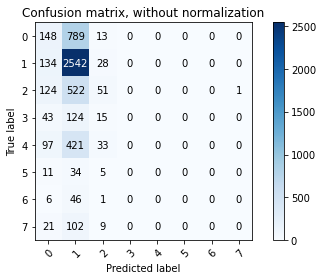

time: 6.07 s (started: 2022-10-30 16:53:45 +00:00)


In [32]:
auc3,acc3,pred_lst3,gt_lst3=compute_predictions(model2)

In [33]:
model3=models.densenet121(pretrained=False)
model3.classifier=nn.Sequential(nn.Linear(1024, 8), nn.Sigmoid())
checkpoint = torch.load('segment/densenet121-segment/resnet50_wt_epoch_11_batch_78_auc_0.7143.pt')
model3.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model3.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

time: 530 ms (started: 2022-10-30 16:53:51 +00:00)


sensitivity-[0.52105263 0.83986686 0.24928367 0.         0.00362976 0.
 0.         0.        ]
specicivity-[0.32630191 0.6896447  0.34455446 0.         0.4        0.
 0.         0.        ]
Balanced Accuracy
0.20172911589642312
Confusion Matrix
Figure(432x288)
f1-score
0.1818933579924472
auc-list


[0.74436854 0.83304254 0.80371113 0.67292026 0.69038223 0.68076281
 0.58104753 0.70801427]
accuracy-list


[0.83890977 0.72575188 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.7142811638600564
mean-auc0.906437969924812


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


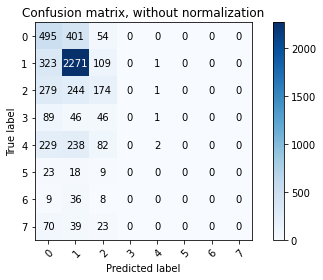

time: 8.5 s (started: 2022-10-30 16:53:51 +00:00)


In [34]:
auc4,acc4,pred_lst4,gt_lst4=compute_predictions(model3)

Computing Test Predictions
auc-list


[0.74386752 0.83184358 0.80415919 0.69251408 0.69300979 0.71328273
 0.58742759 0.71701596]
accuracy-list


[0.82142857 0.63082707 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.7228900563520511
mean-auc0.8923872180451128
sensitivity-[0.42947368 0.87869822 0.1991404  0.         0.00362976 0.
 0.         0.        ]
specicivity-[0.33063209 0.64460119 0.3510101  0.         0.5        0.
 0.         0.        ]
Balanced Accuracy
0.1888677592842581
Confusion Matrix
Figure(432x288)
f1-score
0.1723261122731988


/tmp/ipykernel_4251/898049133.py:27: RuntimeWarning: invalid value encountered in long_scalars
  self.matrix[i, i] / self.matrix[i, :].sum()
/tmp/ipykernel_4251/898049133.py:65: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


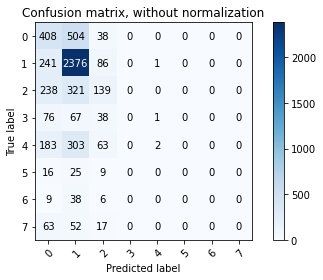

time: 24.2 s (started: 2022-10-30 16:54:00 +00:00)


In [35]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    #print('\n')
    #print(auc_lst)
    #print('\n')
    #print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    #print(auc)
    #print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

print('Computing Test Predictions')


auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)
auc3,acc3,pred_lst3,gt_lst3 = compute_predictions(model2)
auc4,acc4,pred_lst4,gt_lst4 = compute_predictions(model3)
pred_lst = (pred_lst1+pred_lst2+pred_lst3+pred_lst4)/4
gt_lst = (gt_lst1+gt_lst2+gt_lst3+gt_lst4)/4
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)
